# Proper big notebook

In [307]:
#import packages
import time
import os
import platform

import pandas as pd
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, roc_curve, auc, accuracy_score, precision_recall_curve
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import seaborn as sns
import imageio

mpl.rcParams['figure.figsize'] = (10, 6)
mpl.rcParams['axes.grid'] = True
mpl.rcParams['legend.fontsize'] = 'large'



In [265]:
if platform.system() == "Darwin":
    root_directory = '/Users/lorenzobarbiero/Documents/GitHub/CNN-Gait-recognition'
else:
    root_directory = None ##Francesco qui metti il tuo path
    
print('root directory is ' + root_directory)

root directory is /Users/lorenzobarbiero/Documents/GitHub/CNN-Gait-recognition


## Train/Test Split

Load reference file, separate the two different data types and one hot encode the labels

In [266]:
# Create a dataframe containing all the files and the labels from the reference file
reference_df = pd.read_csv(root_directory+'/reference_document.csv')
reference_df


,File Name,Path from Root,Type,Label
0,Sbj2_steppage_T9_P.csv,subject2/steppage/trial9/,pressure,steppage
1,Sbj2_steppage_T9_S.csv,subject2/steppage/trial9/,skeleton,steppage
2,Sbj2_steppage_T14_P.csv,subject2/steppage/trial14/,pressure,steppage
3,Sbj2_steppage_T14_S.csv,subject2/steppage/trial14/,skeleton,steppage
4,Sbj2_steppage_T13_S.csv,subject2/steppage/trial13/,skeleton,steppage
...,...,...,...,...
2875,Sbj9_trendelenburg_T11_S.csv,subject9/trendelenburg/trial11/,skeleton,trendelenburg
2876,Sbj9_trendelenburg_T18_S.csv,subject9/trendelenburg/trial18/,skeleton,trendelenburg
2877,Sbj9_trendelenburg_T18_P.csv,subject9/trendelenburg/trial18/,pressure,trendelenburg
2878,Sbj9_trendelenburg_T20_S.csv,subject9/trendelenburg/trial20/,skeleton,trendelenburg


In [267]:
# Create a dataframe containing all the files and the labels from the reference file
reference_df = pd.read_csv(root_directory+'/reference_document.csv')

#split the dataframe into skeleton and pressure, drop the type column
reference_df_s = reference_df[reference_df['Type']=='skeleton'].drop(columns='Type')
reference_df_p = reference_df[reference_df['Type']=='pressure'].drop(columns='Type')

#train_test split
train_s, val_s = train_test_split(reference_df_s, test_size=0.2, stratify=reference_df_s['Label'], random_state=123)
train_p, val_p = train_test_split(reference_df_p, test_size=0.2, stratify=reference_df_p['Label'], random_state=123)

#frequence counts
print("Train Skelly")
print(train_s['Label'].value_counts())
print("Val Skelly")
print(val_s['Label'].value_counts())
print("Train Pressure")
print(train_p['Label'].value_counts())
print("Val Pressure")
print(val_p['Label'].value_counts())

Train Skelly
trendelenburg    192
steppage         192
stifflegged      192
antalgic         192
lurching         192
normal           192
Name: Label, dtype: int64
Val Skelly
steppage         48
normal           48
lurching         48
stifflegged      48
trendelenburg    48
antalgic         48
Name: Label, dtype: int64
Train Pressure
trendelenburg    192
steppage         192
stifflegged      192
antalgic         192
lurching         192
normal           192
Name: Label, dtype: int64
Val Pressure
steppage         48
normal           48
lurching         48
stifflegged      48
trendelenburg    48
antalgic         48
Name: Label, dtype: int64


1 hot encode labels

In [268]:
#1 hot encode labels
train_s_labs = pd.get_dummies(data = train_s, columns=['Label'])
val_s_labs = pd.get_dummies(data = val_s, columns=['Label'])
train_p_labs = pd.get_dummies(data = train_p, columns=['Label'])
val_p_labs = pd.get_dummies(data = val_p, columns=['Label'])

val_p_labs

,File Name,Path from Root,Label_antalgic,Label_lurching,Label_normal,Label_steppage,Label_stifflegged,Label_trendelenburg
974,Sbj3_steppage_T1_P.csv,subject3/steppage/trial1/,0,0,0,1,0,0
2810,Sbj9_normal_T12_P.csv,subject9/normal/trial12/,0,0,1,0,0,0
1336,Sbj8_lurching_T8_P.csv,subject8/lurching/trial8/,0,1,0,0,0,0
1328,Sbj8_lurching_T6_P.csv,subject8/lurching/trial6/,0,1,0,0,0,0
337,Sbj5_stiff-legged_T8_P.csv,subject5/stiff-legged/trial8/,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...
98,Sbj2_stiff-legged_T19_P.csv,subject2/stiff-legged/trial19/,0,0,0,0,1,0
191,Sbj2_normal_T2_P.csv,subject2/normal/trial2/,0,0,1,0,0,0
786,Sbj4_antalgic_T17_P.csv,subject4/antalgic/trial17/,1,0,0,0,0,0
1613,Sbj6_normal_T15_P.csv,subject6/normal/trial15/,0,0,1,0,0,0


Train/test split

## Preprocessing functions

### Common useful functions

### Skeleton specific functions

In [269]:
#load data function for skeleton

def load_data_sk(index, ref_df, debug = 0):
    #if isinstance(data_dir, bytes):
    #    data_dir = data_dir.decode()
    #if isinstance(file_name, bytes):
    #    file_name = file_name.decode()
        
    file_name = ref_df.loc[ref_df.index[index],'File Name']    
    filepath = root_directory + '/dataset/' + ref_df.loc[ref_df['File Name']==file_name,'Path from Root'] + file_name
    
    
    # Read the CSV file into a pandas DataFrame, Drop time signature column and last empty column
    df_skelly = pd.read_csv(filepath.iloc[0], header=None)
    df_skelly = df_skelly.drop([df_skelly.columns[0],df_skelly.columns[-1]], axis=1)
        
    #convert to np array and reshape
    data = df_skelly.to_numpy().reshape((-1,32,3))        
    
    
    if debug == 1:
        print(file_name)
        print(filepath.iloc[0])
        print(data.shape)
        
    return data.squeeze()

(239, 32, 3)


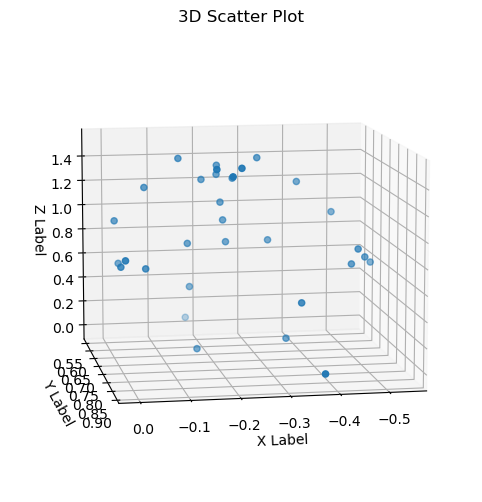

In [305]:
# example of loading

a = load_data_sk(3, reference_df_s)
#print(a)
print(a.shape)

#plot example
plotdata = a[150]
plotdata

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(plotdata[:, 0], plotdata[:, 1], plotdata[:, 2])
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.set_title('3D Scatter Plot')
ax.view_init(elev=10, azim=80)
plt.show()

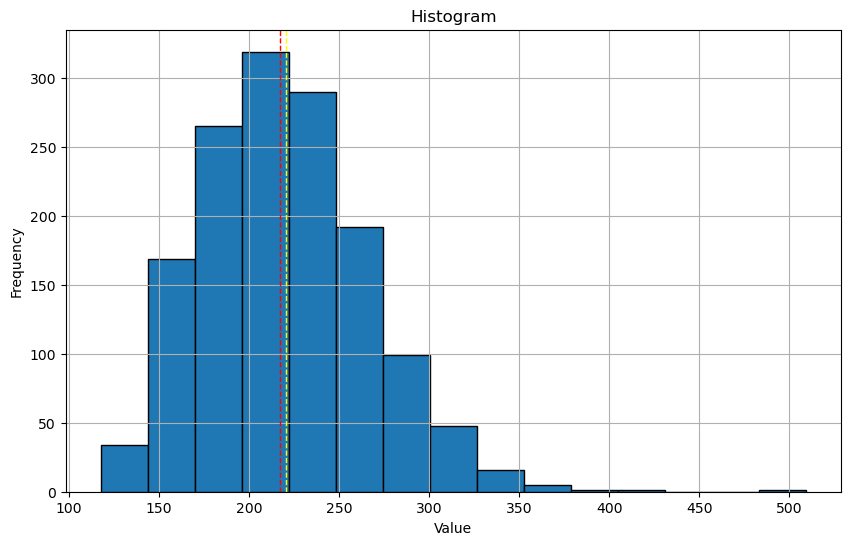

Median of data (red) 217.0
Mean of data (yellow) 220.38888888888889
Standard dev of data 45.652797637152155


In [276]:
# check length of walking samples
hist = []

for i in range(0,len(reference_df_s)):
    data = load_data_sk(i, reference_df_s)
    hist.append(data.shape[0])
    
# Create a histogram
plt.hist(hist, bins=15, edgecolor='black')

# Add a vertical line for the median
plt.axvline(np.median(hist), color='red', linestyle='dashed', linewidth=1)
plt.axvline(np.mean(hist), color='yellow', linestyle='dashed', linewidth=1)

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram')

# Show the plot
plt.show()
print("Median of data (red)",np.median(hist))
print("Mean of data (yellow)",np.mean(hist))
print("Standard dev of data", np.std(hist))

#### Cropping/padding function
Given the variability in the length of the sample of the walking data we need to crop and pad, we decided to do it around the median value at 217 samples, we need to figure out the best padding, at the moment 'edge' seems to be the most reasonable one since it corresponds to a still human being

In [295]:
def random_crop(data, target_size=217, center_crop=False):
    N = data.shape[0]

    # Return data if correct size
    if N == target_size:
        return data

    # If data is too small, then pad with zeros
    if N < target_size:
        tot_pads = target_size - N
        left_pads = int(np.ceil(tot_pads / 2))
        right_pads = int(np.floor(tot_pads / 2)) # tot_pads - left_pads
        return np.pad(data, [left_pads, right_pads], mode='edge')

    # Random Crop (always centered if center_crop=True)
    if center_crop:
        from_ = int((N / 2) - (target_size / 2))
    else:
        from_ = np.random.randint(0, np.floor(N - target_size))
    return data[from_:from_ + target_size]

In [296]:
a = load_data_sk(21, reference_df_s)
a_crop = random_crop(a)
print(a.shape, a_crop.shape)
print(a_crop)

(199, 32, 3) (217, 50, 21)
[[[-0.295876 -0.295876 -0.295876 ...  0.830765  0.830765  0.830765]
  [-0.295876 -0.295876 -0.295876 ...  0.830765  0.830765  0.830765]
  [-0.295876 -0.295876 -0.295876 ...  0.830765  0.830765  0.830765]
  ...
  [-0.371983 -0.371983 -0.371983 ...  1.524394  1.524394  1.524394]
  [-0.371983 -0.371983 -0.371983 ...  1.524394  1.524394  1.524394]
  [-0.371983 -0.371983 -0.371983 ...  1.524394  1.524394  1.524394]]

 [[-0.295876 -0.295876 -0.295876 ...  0.830765  0.830765  0.830765]
  [-0.295876 -0.295876 -0.295876 ...  0.830765  0.830765  0.830765]
  [-0.295876 -0.295876 -0.295876 ...  0.830765  0.830765  0.830765]
  ...
  [-0.371983 -0.371983 -0.371983 ...  1.524394  1.524394  1.524394]
  [-0.371983 -0.371983 -0.371983 ...  1.524394  1.524394  1.524394]
  [-0.371983 -0.371983 -0.371983 ...  1.524394  1.524394  1.524394]]

 [[-0.295876 -0.295876 -0.295876 ...  0.830765  0.830765  0.830765]
  [-0.295876 -0.295876 -0.295876 ...  0.830765  0.830765  0.830765]
  [-0

### Plate specific functions

In [271]:
#load data function for pressure

def load_data_pp(index, ref_df, debug = 0):
        
    file_name = ref_df.loc[ref_df.index[index],'File Name']   
    filepath = root_directory + '/dataset/' + ref_df.loc[ref_df['File Name']==file_name,'Path from Root'] + file_name
    
    dfplate = pd.read_csv(filepath.iloc[0], header=None).to_numpy()
    
    if debug == 1:
        print(file_name)
        print(filepath.iloc[0])
        print(data.shape)
    
    return dfplate.squeeze()

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(128, 48)


<Axes: >

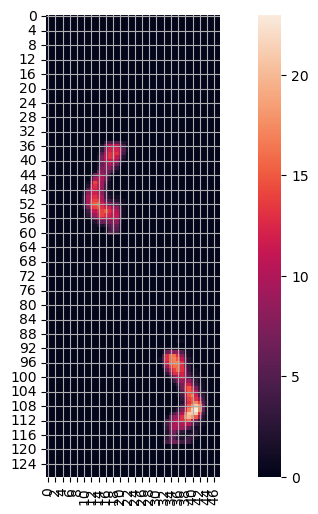

In [313]:
# loading example
b = load_data_pp(12, reference_df_p)
print(b)
print(b.shape)

#and plot an example
sns.heatmap(b, square= True)

Some good ideas for preprocessing could be:

Normalize the dataset to lose the dependence over the weigth of the participant

Shift all matrices to be centered wrt the barycenter

In [347]:
def bar (data):
    # the first dimension (128) is along y
    # Compute the weighted average (barycenter) along each dimension
    y_barycenter = np.average(np.arange(data.shape[0]), weights=np.sum(data, axis=1))
    x_barycenter = np.average(np.arange(data.shape[1]), weights=np.sum(data, axis=0))
    print("Barycenter coordinates (x,y) = ",x_barycenter,y_barycenter)

    # Compute the distances between each point and the barycenter
    y_distances = np.arange(data.shape[0]) - y_barycenter
    x_distances = np.arange(data.shape[1]) - x_barycenter

    # Shift the foot pressure matrix to be centered on the barycenter
    shifted_matrix = np.roll(data, int(round(y_distances.mean())), axis=0)
    shifted_matrix = np.roll(shifted_matrix, int(round(x_distances.mean())), axis=1)
    
    return shifted_matrix

Barycenter coordinates (x,y) =  27.79927558104437 79.38877150618775


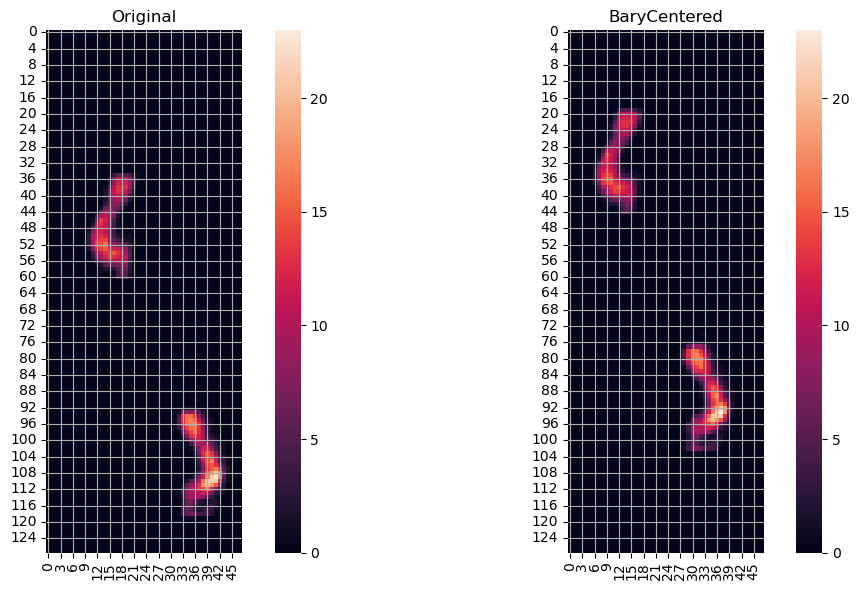

In [352]:
shifted_b=bar(b)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.heatmap(b, square= True, ax=axes[0])
axes[0].set_title('Original')

sns.heatmap(shifted_b, square= True,ax=axes[1])
axes[1].set_title('BaryCentered')

plt.tight_layout()
plt.show()

In [351]:
#check
shifted_b = bar(shifted_b)

Barycenter coordinates (x,y) =  23.79927558104437 63.388771506187744


Coordinates are close enough to the expected (24,64)

## Input data pipeline